In [26]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import nibabel as nib
import scipy.io
import time
import pandas as pd
import glob
import re
import os
from tqdm import tqdm

In [4]:
def ReadModeFiles(index,list_file):
        NbM = len(list_file)
        temp_modes = [None] * NbM  # empty list of size NbM 
        for i, filename in enumerate(list_file):
            metabo_mode = pd.read_csv(filename, header=None, skiprows=[0]).values
            m = re.search("[0-9]T_.{1,6}_Exact", filename)
            name = bytes(filename[m.span()[0]+3:m.span()[1]-6].strip(), 'utf8')
            temp_modes[index[name]] = metabo_mode
        return temp_modes

In [5]:
list_file = glob.glob('../MetabModes/7T_TE0/*Exact_Modes.txt')

In [17]:
b_RemWat = True
WatSuppComp = 32 # Number of component for the HSVD water removal (advised: 16 at 3T and 32 at 7T)
minFreq = -150 # -150Hz(7T) # +-0.5ppm
maxFreq = 150 # 150
parallel_jobs = 20

bandwidth = 3000 # 3khz
dwell_time = 1/bandwidth

# Simulation
nSpectra=100
nRandomLipid=10
MaxLipidScaling=70

MaxSNR=10
MinSNR=1

N=960
NMRFreq= 297189866.0 #127.7 *10**6 #297189866.0 #
sampling_rate = 1/dwell_time  # Hz  sampling_rate = 1/dwell_time

MaxAcquDelay=0.002
MaxFreq_Shift = 40
MinPeak_Width=20#4
MaxPeak_Width=100#20

In [27]:
# Calculate the time vector
t = np.arange(N) / sampling_rate

# Simulation parameters
AcquDelay = (np.random.rand(nSpectra, 1)-0.5)*2 * MaxAcquDelay

PhShift=np.random.rand(nSpectra, 1) * 2 * np.pi
TimeSerieClean = np.zeros(( N), dtype=np.complex64)

FreqShift = (np.random.rand(nSpectra, 1)*2 - 1) * MaxFreq_Shift

PeakWidth = MinPeak_Width + np.random.rand(nSpectra, 1) * (MaxPeak_Width - MinPeak_Width)
ponder_peaks = np.random.rand(nSpectra, 1)
PeakWidth_Gau = np.multiply(ponder_peaks, PeakWidth)
PeakWidth_Lor = np.multiply(1-ponder_peaks, PeakWidth)

SNR = MinSNR + np.random.rand(nSpectra, 1) * (MaxSNR - MinSNR)



########################################
#### Perpare metabolite information ####
########################################
def ReadModeFiles(index,list_file):
    NbM = len(list_file)
    temp_modes = [None] * NbM  # empty list of size NbM 
    for i, filename in enumerate(list_file):
        metabo_mode = pd.read_csv(filename, header=None, skiprows=[0]).values
        m = re.search("[0-9]T_.{1,6}_Exact", filename)
        name = bytes(filename[m.span()[0]+3:m.span()[1]-6].strip(), 'utf8')
        temp_modes[index[name]] = metabo_mode
    return temp_modes

index = {}  # mapping of metabolite name to index
mean_std_csv = pd.read_csv('../MetabModes/Metab_Mean_STD.txt', header=None).values

for i, v in enumerate(mean_std_csv[:, 0].astype(str)):
    index[ bytes(v.strip(), 'utf8') ] = i

mean_std = mean_std_csv[:, 1:].astype(np.float32)

list_file = glob.glob('../MetabModes/7T_TE0/*Exact_Modes.txt')
NbM = len(list_file)
metabo_modes = [[[None] for j in range(NbM)] for i in range(6)]
temp_modes = ReadModeFiles(index,list_file)
metabo_modes[0]=temp_modes

# Metabolic parameters
TempMetabData = np.zeros( (len(metabo_modes[0]), N), dtype=np.complex64)
BasisI = 0#np.floor(np.random.rand(nSpectra, 1) * 6)

Amplitude = mean_std[:, 1]* np.random.randn(nSpectra, NbM) + mean_std[:, 0]
Amplitude = Amplitude.clip(min=0)


#############################
#### Simulate metabolite ####
#############################
MetabSpectrum = np.zeros((nSpectra, N), dtype=np.complex128)
for n in tqdm(range(nSpectra)):

    TempMetabData =0*TempMetabData
    for f, mode in enumerate(metabo_modes[0]):   # metabo_modes[int(BasisI[n])]
            Freq = ((4.7-mode[:, 0]) * 1e-6 * NMRFreq)[...,None]

            for Nuc in range(len(Freq)):
                if (mode[Nuc, 0] > 0.0) & (mode[Nuc, 0] < 4.5)  : # only for the window of interest 
                    TempMetabData[f, :] += mode[Nuc, 1][...,None] * np.exp(1j * mode[Nuc, 2][...,None]) * np.exp(2 * np.pi * 1j * (t + AcquDelay[n])  * (Freq[Nuc]))

    TimeSerieClean=0*TimeSerieClean
    for f, _ in enumerate(metabo_modes[0]):  # metabo_modes[int(BasisI[ex])]
        TimeSerieClean[:] += Amplitude[n, f] * TempMetabData[f, :]* np.exp(1j * PhShift[n])  

    TimeSerieClean[:] *= np.exp( (t* 1j * 2 * np.pi * FreqShift[n] ) + (- (np.square(t)) * (np.square(PeakWidth_Gau[n]))) + ((np.absolute(t)) * (- PeakWidth_Lor[n]) ) )
    SpectrumTemp = np.fft.fftshift(np.fft.fft(TimeSerieClean[:],axis=0))

    # SNR
    NCRand=(np.random.randn(N) + 1j * np.random.randn(N))
    TimeSerie = TimeSerieClean + np.fft.ifft(SpectrumTemp.std()/0.65 / SNR[n] * NCRand,axis=0)

    MetabSpectrum[n] = np.fft.fftshift(np.fft.fft(TimeSerie))

100%|███████████████████████████████████████| 100/100 [00:03<00:00, 26.03it/s]


In [28]:
TempMetabData[10,10]

(-4.4847097-1.2667291j)

In [36]:
#! pip install h5py nibabel pandas glob2 regex
version = 'v_hauke_test_water'
p = '../PaulTrainData/3DMRSIMAP_Vol_04_A_1_2024-09-06_L2_0p0005/TrainData/'+'TrainData_'+version+'.h5'

fh = h5py.File(p, 'r')
print(fh.keys())

print(fh['spectra'].shape)
spectra = np.array(fh['spectra'][:1000,:])
lipid_proj = np.array(fh['lipid_proj'][:1000,:])
lipid = np.array(fh['lipid'][:1000,:])
water = np.array(fh['water'][:1000,:])
metab = np.array(fh['metab'][:1000,:])

<KeysViewHDF5 ['lipid', 'lipid_proj', 'lipid_projOP', 'metab', 'spectra', 'water']>
(20, 960)


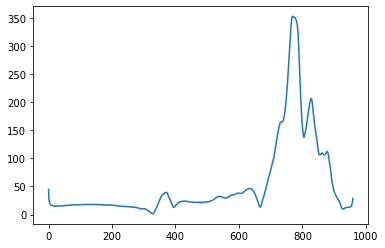

In [42]:
i = 1

Slice = np.abs(lipid[i,:])

plt.plot(Slice)

In [22]:
version = 'v4_2'
p = '../PaulTrainData/3DMRSIMAP_Vol_04_A_1_2024-09-06_L2_0p0005/TrainData/'+'TrainData_'+version+'.h5'

fh = h5py.File(p, 'r')
print(fh.keys())

print(fh['spectra'].shape)
spectra = np.array(fh['spectra'][:1000,:])
lipid_proj = np.array(fh['lipid_proj'][:1000,:])
lipid = np.array(fh['lipid'][:1000,:])
water = np.array(fh['water'][:1000,:])
metab = np.array(fh['metab'][:1000,:])

<KeysViewHDF5 ['lipid', 'lipid_proj', 'lipid_projOP', 'metab', 'spectra', 'water']>
(100000, 960)


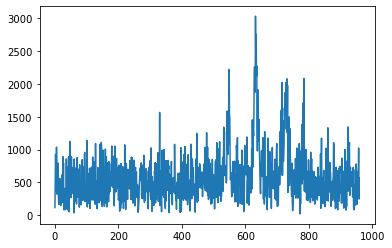

In [27]:
plt.plot(np.abs(spectra[0,:]-lipid[0,:]-water[0,:]))

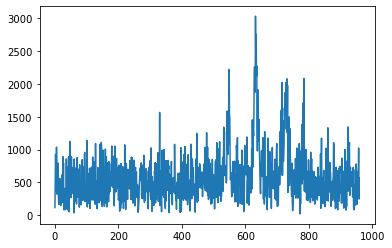

In [23]:
plt.plot(np.abs(metab[0,:]))

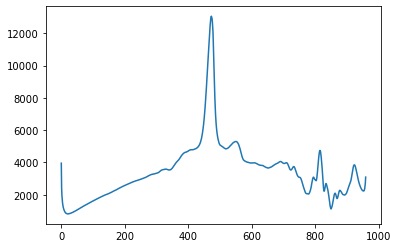

In [16]:
plt.plot(np.abs(lipid_proj[0,:]))

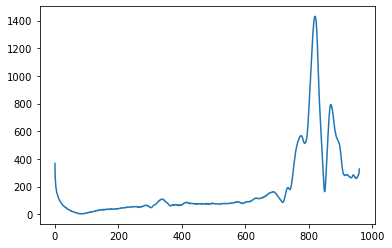

In [15]:
plt.plot(np.abs(lipid[0,:]))

In [ ]:
plt.plot(np.abs(lipid[0,:]))

(1000, 960)
(1000, 960)
(1000, 960)


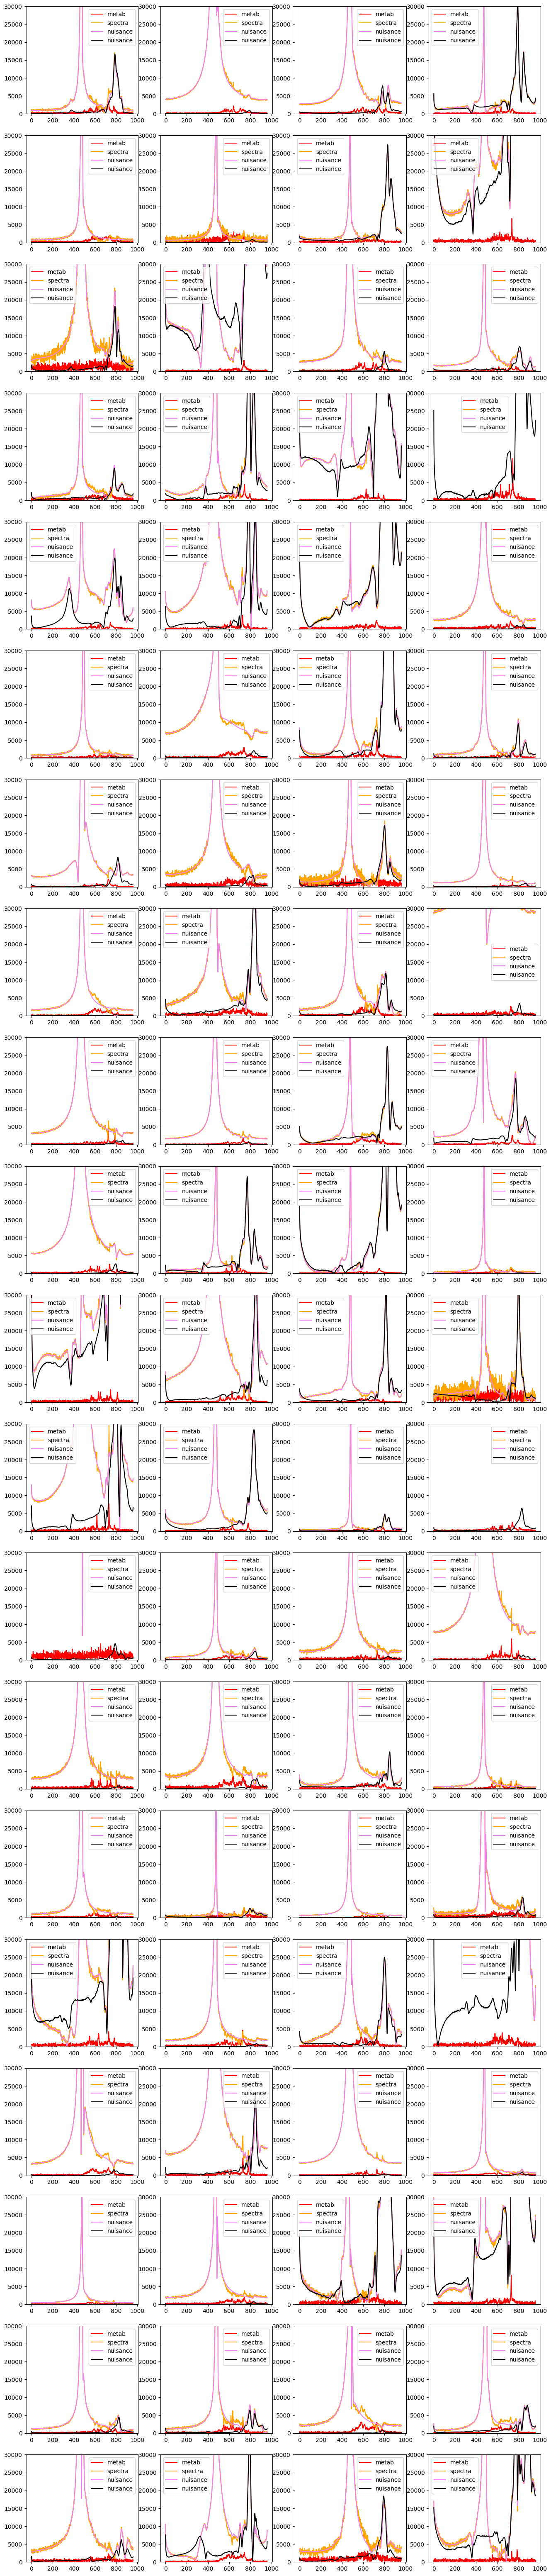

In [11]:

#water = np.array(fh['water'])

print(spectra.shape)
print(lipid_proj.shape)
print(lipid.shape)

nrows,ncols=20,4

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4,nrows*4), sharey=False)
for i in range(nrows):
    for ii in range(ncols):
        sl = i*ncols + ii +100
        ax[i,ii].plot(np.abs(spectra[sl]-lipid[sl]-water[sl]), label='metab', color='red')
        ax[i,ii].plot(np.abs(spectra[sl]), label='spectra', color='orange')
        #ax[i,ii].plot(np.abs(lipid_proj[sl]), label='proj', color='blue')
        ax[i,ii].plot(np.abs(lipid[sl]+water[sl]), label='nuisance', color='violet')
        ax[i,ii].plot(np.abs(lipid[sl]), label='nuisance', color='black')
        
        ax[i,ii].set_ylim([0,30000])
        ax[i,ii].legend()
        #ax[i,ii].title.set_text('index: ' + str(sl))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
#plt.savefig("images/Subject"+sub+"_"+exp+"_lipidrem")
plt.show()


In [9]:
version = 'v4_2'
p = '/workspace/walinet/PaulTrainData/3DMRSIMAP_Vol_06_A_1_2024-08-22_L2_0p0005/TrainData/'+'TrainData_'+version+'.h5'

fh = h5py.File(p, 'r')
print(fh.keys())

<KeysViewHDF5 ['lipid', 'lipid_proj', 'lipid_projOP', 'spectra']>


(100000, 960)
(100000, 960)
(100000, 960)


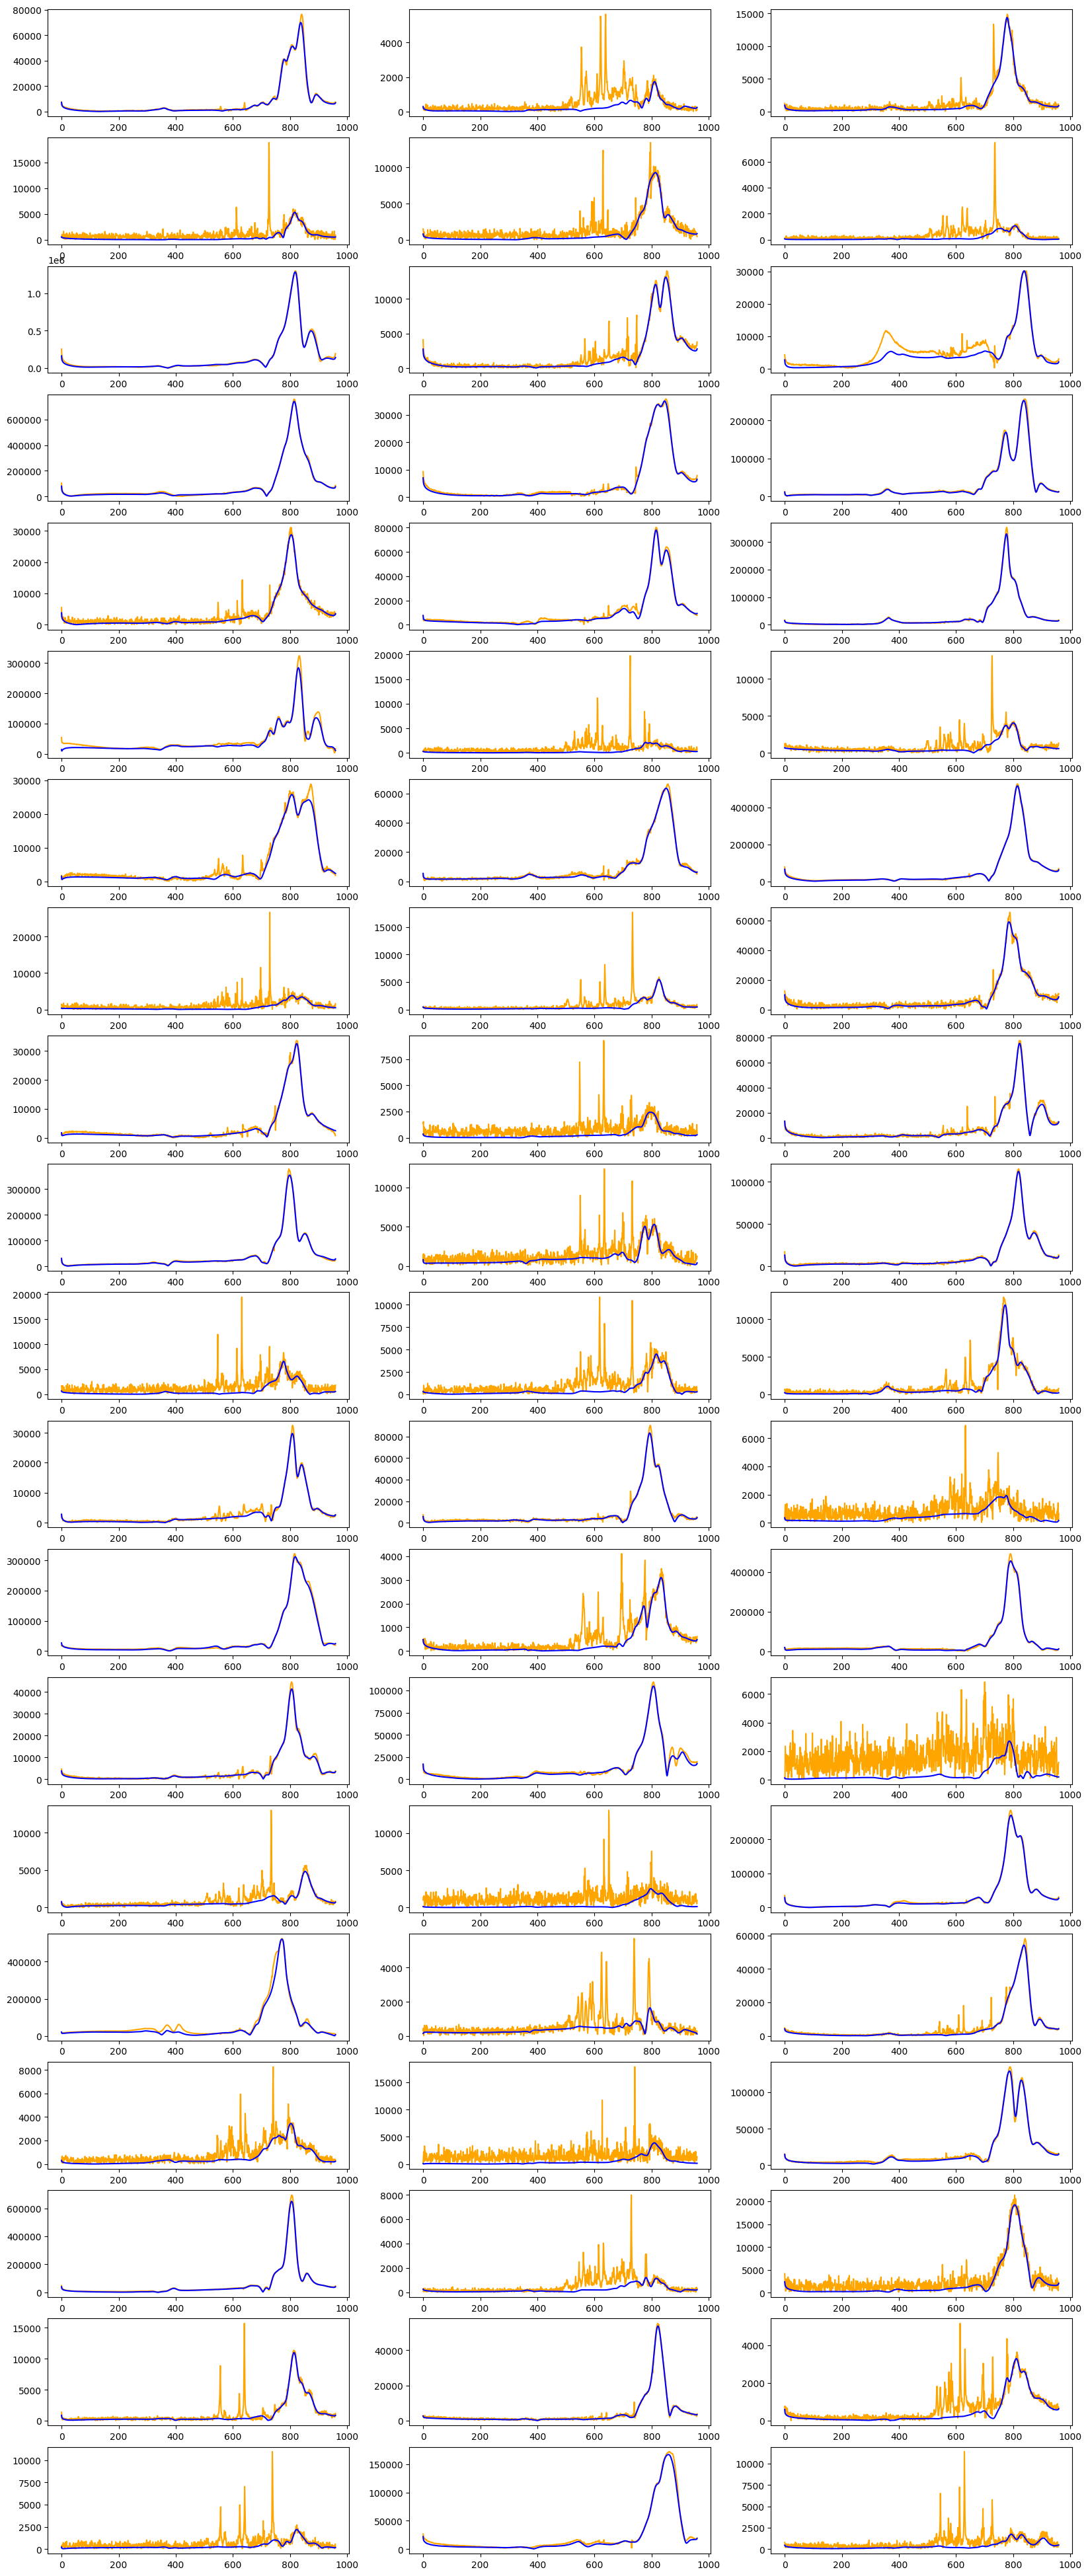

In [10]:
spectra = np.array(fh['spectra'])
lipid_proj = np.array(fh['lipid_proj'])
lipid = np.array(fh['lipid'])
water = np.array(fh['water'])

print(spectra.shape)
print(lipid_proj.shape)
print(lipid.shape)

fig, ax = plt.subplots(nrows=20, ncols=3, figsize=(20,50), sharey=False)
for i in range(20):
    for ii in range(3):
        sl = i*3 + ii

        ax[i,ii].plot(np.abs(spectra[sl]), label='pred', color='orange')
        ax[i,ii].plot(np.abs(lipid_proj[sl]), label='pred', color='blue')
        #ax[i,ii].set_ylim([0,3*10**11])
        #ax[i,ii].legend()
        #ax[i,ii].title.set_text('index: ' + str(sl))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
#plt.savefig("images/Subject"+sub+"_"+exp+"_lipidrem")
plt.show()
